In [1]:
import sys
sys.path.insert(0,'..')
sys.path.insert(0,'/Users/ryan/github/prosodic')
sys.path.insert(0,'/Users/ryan/github/lltk')
from llmdh import *
from sqlitedict import SqliteDict
import os

In [2]:
corproot='/Users/ryan/github/bechdeltest/data/corpus'
dfmeta = pd.read_csv(corproot+'/metadata.csv').set_index('id')
dfmeta['release_date']=pd.to_numeric(dfmeta['release_date'], errors='coerce')
dfmeta['dec']=dfmeta['release_date']//10*10
dfmeta.dec.value_counts().sort_index()

dec
1900.0      1
1910.0      2
1920.0      5
1930.0     21
1940.0     25
         ... 
1980.0    192
1990.0    420
2000.0    554
2010.0    635
2020.0     85
Name: count, Length: 13, dtype: int64

In [3]:
dbfn=os.path.join(PATH_DATA,'data.bechdel.db')
db = SqliteDict(dbfn, flag='r', autocommit=True)

In [4]:
pd.options.display.max_rows=100
keys=[k for k in db.keys() if type(db[k]) is pd.DataFrame]
sumdf=pd.DataFrame([db[k].mean(numeric_only=True) for k in keys], index=keys).rename_axis('id').dropna()
sumdf.sort_values('female_characters_speak_about_something_other_than_a_man')
dfall=sumdf.join(dfmeta)
dfall['release_date']=pd.to_numeric(dfall['release_date'], errors='coerce')
dfall
# sumdf.sort_values('female_characters_speak_to_each_other')

,female_characters_speak_to_each_other,female_characters_speak_about_something_other_than_a_man,scene_num,num_female_characters,num_male_characters,name,source,file_name,script_url,tmdb_title,title,tmdb_release_date,release_date,tmdb_id,tmdb_overview,overview,imdb_title,imdb_release_date,imdb_id,dec
id,,,,,,,,,,,,,,,,,,,,
10-Things-I-Hate-About-You,0.461538,0.243590,44.435897,1.641026,2.294872,10 Things I Hate About You,imsdb,10-Things-I-Hate-About-You,https://imsdb.com/scripts/10-Things-I-Hate-Abo...,10 Things I Hate About You,10 Things I Hate About You,1999-03-30,1999.0,4951.0,"On the first day at his new school, Cameron in...","On the first day at his new school, Cameron in...",10 Things I Hate About You,1999.0,147800.0,1990.0
A-Dry-White-Season,0.220000,0.080000,32.760000,1.360000,4.940000,A Dry White Season,scriptsavant,A-Dry-White-Season,https://secureservercdn.net/198.71.233.72/p2z....,A Dry White Season,A Dry White Season,1989-01-01,1989.0,32075.0,"During the 1976 Soweto uprising, a white schoo...","During the 1976 Soweto uprising, a white schoo...",A Dry White Season,1989.0,97243.0,1980.0
Airplane-II-The-Sequel,0.107955,0.062500,128.363636,0.676136,2.261364,Airplane II: The Sequel,dailyscript,Airplane-II-The-Sequel,https://www.dailyscript.com/scripts/Airplane2_...,Airplane II: The Sequel,Airplane II: The Sequel,1982-12-10,1982.0,2665.0,A faulty computer causes a passenger space shu...,A faulty computer causes a passenger space shu...,Airplane II: The Sequel,1982.0,83530.0,1980.0
The-Parent-Trap,0.822222,0.355556,32.533333,3.488889,1.555556,The Parent Trap,scriptsavant,The-Parent-Trap,https://secureservercdn.net/198.71.233.72/p2z....,The Parent Trap,The Parent Trap,1998-07-28,1998.0,9820.0,Hallie Parker and Annie James are identical tw...,Hallie Parker and Annie James are identical tw...,The Parent Trap,1998.0,120783.0,1990.0
Pans-Labyrinth,0.228261,0.239130,57.673913,1.380435,1.706522,Pans Labyrinth,scriptsavant,Pans-Labyrinth,https://secureservercdn.net/198.71.233.72/p2z....,Pan's Labyrinth,Pan's Labyrinth,2006-10-10,2006.0,1417.0,Living with her tyrannical stepfather in a new...,Living with her tyrannical stepfather in a new...,Pan's Labyrinth,2006.0,457430.0,2000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Horrible-Bosses,0.061728,0.012346,62.839506,0.345679,3.012346,Horrible Bosses,actorpoint,Horrible-Bosses,https://www.actorpoint.com/movie-scripts/scrip...,Horrible Bosses,Horrible Bosses,2011-07-08,2011.0,51540.0,"For Nick, Kurt and Dale, the only thing that w...","For Nick, Kurt and Dale, the only thing that w...",Horrible Bosses,2011.0,1499658.0,2010.0
Transformers-The-Movie,0.062500,0.020833,26.791667,0.270833,5.562500,Transformers: The Movie,imsdb,Transformers-The-Movie,https://imsdb.com/scripts/Transformers-The-Mov...,The Transformers: The Movie,The Transformers: The Movie,1986-08-08,1986.0,1857.0,The Autobots must stop a colossal planet-consu...,The Autobots must stop a colossal planet-consu...,The Transformers: The Movie,1986.0,92106.0,1980.0
American-President-The,0.301205,0.156627,56.506024,1.493976,2.734940,"American President, The",actorpoint,American-President-The,https://www.actorpoint.com/movie-scripts/scrip...,The American President,The American President,1995-11-17,1995.0,9087.0,"Widowed U.S. president Andrew Shepherd, one of...","Widowed U.S. president Andrew Shepherd, one of...",The American President,1995.0,112346.0,1990.0


In [5]:
dfall.to_pickle('data.bechdel.dfall.pkl')

In [6]:
# importing the module
# !pip install imdbpy
import imdb
 
# creating instance of IMDb
ia = imdb.IMDb()
imdb_ids = dfall.imdb_id.dropna().apply(int).apply(str)
# imdb_ids

In [7]:
dbgenre=SqliteDict('data.imdb_genre.db', flag='c', autocommit=True)
for idx in tqdm(imdb_ids):
    if idx not in dbgenre:
        dbgenre[idx]=ia.get_movie(idx)
    time.sleep(0.005)
 

100%|██████████| 557/557 [00:51<00:00, 10.78it/s] 


In [8]:
def tostr(x):
    try:
        return str(int(x))
    except:
        return ''
    
dfall['imdb_id']=dfall.imdb_id.apply(tostr)

dfall2 = pd.DataFrame(
    {**d, 'genre':g}
    for d in dfall.reset_index().to_dict('records')
    for g in dbgenre.get(d['imdb_id'],{}).get('genres',[])
    if g not in {'Music','Short'}
).set_index('id')

# dfall['genre']=[
#     dbgenre.get(idx,{}).get('genres',[''])[0]
#     for idx in dfall.imdb_id
# ]
# # dfall['genre']
# dfall2

In [9]:
dfall['dec']=dfall['release_date']//10*10
dfall.dec.value_counts().sort_index()

dec
1900.0      1
1910.0      2
1920.0      2
1930.0      8
1940.0     20
1950.0     26
1960.0     26
1970.0     58
1980.0     55
1990.0     78
2000.0    101
2010.0    110
2020.0     70
Name: count, dtype: int64

In [10]:
# dfall.sort_values('female_characters_speak_about_something_other_than_a_man')

In [11]:
# alt.Chart(dfall.reset_index()).mark_point().encode(
#     x='female_characters_speak_to_each_other',
#     y='female_characters_speak_about_something_other_than_a_man',
#     color='genre',
#     tooltip=['id']
# ) + alt.Chart(dfall.reset_index()).mark_text(dx=5, dy=-5, align='left').encode(
#     x='female_characters_speak_to_each_other',
#     y='female_characters_speak_about_something_other_than_a_man',
#     text='id',
#     tooltip=['id','genre','release_date']
# ).properties(
#     width=800,
#     height=600
# ).interactive()

In [12]:
# # !pip install scikit-misc
# import plotnine as p9
# fig=p9.ggplot(dfall.reset_index(), p9.aes(x='release_date', y='female_characters_speak_about_something_other_than_a_man', label='id'))
# fig+=p9.geom_point(p9.aes(color='genre'))
# fig+=p9.geom_smooth(method='loess')
# fig

In [13]:
# !pip install scikit-misc
import plotnine as p9

def plot_trends(y='female_characters_speak_to_each_other'):
    figdf=dfall2[dfall2.genre.isin({'Drama','Comedy','Action'})].query('release_date>=1940')
    fig=p9.ggplot(figdf.reset_index(), p9.aes(x='release_date', y=y, label='id'))
    fig+=p9.geom_point(p9.aes(color='genre'))
    fig+=p9.geom_smooth(method='loess')
    fig+=p9.facet_wrap('genre')
    return fig

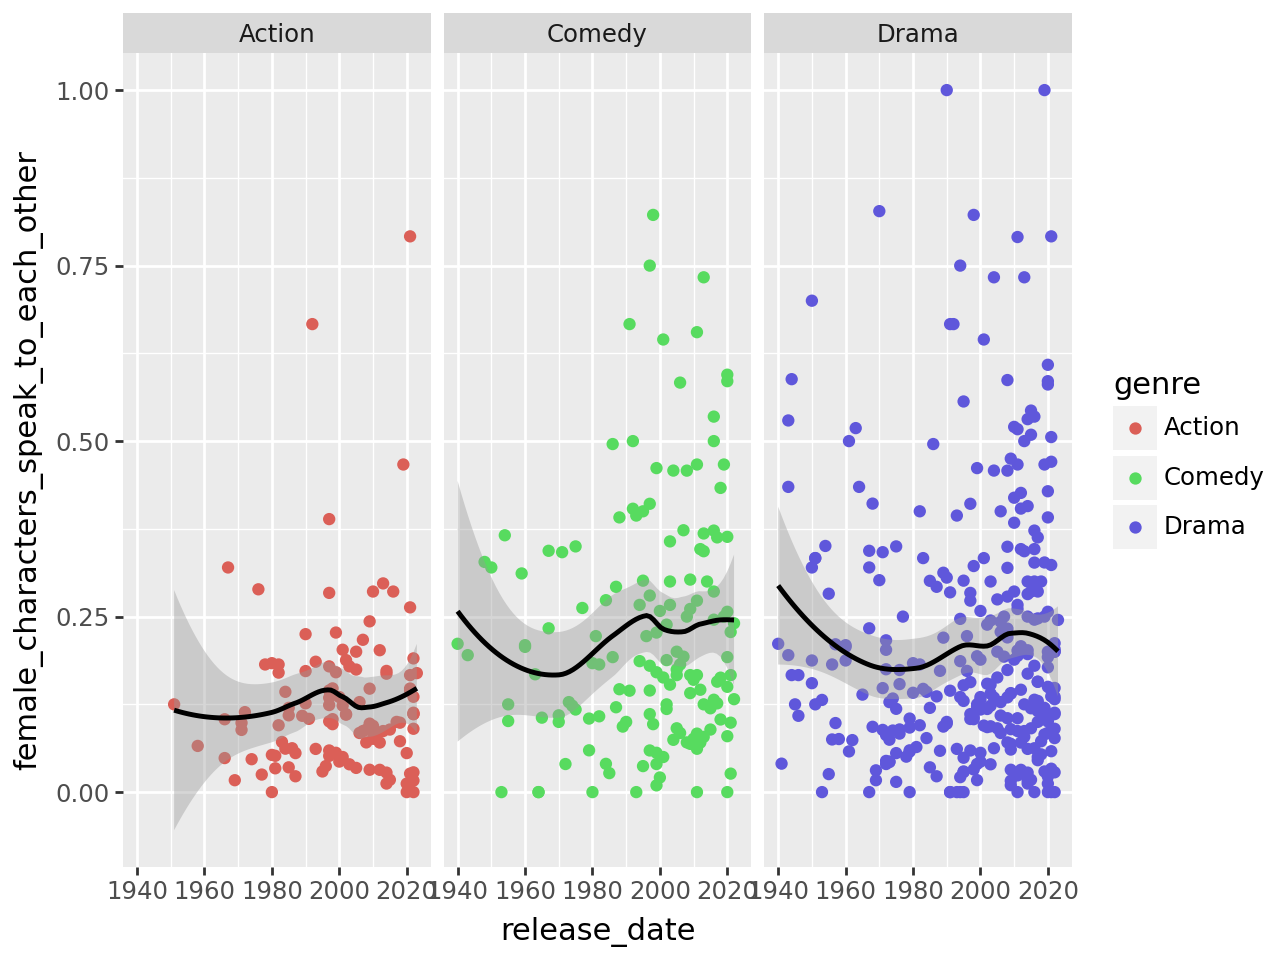

In [14]:
plot_trends()

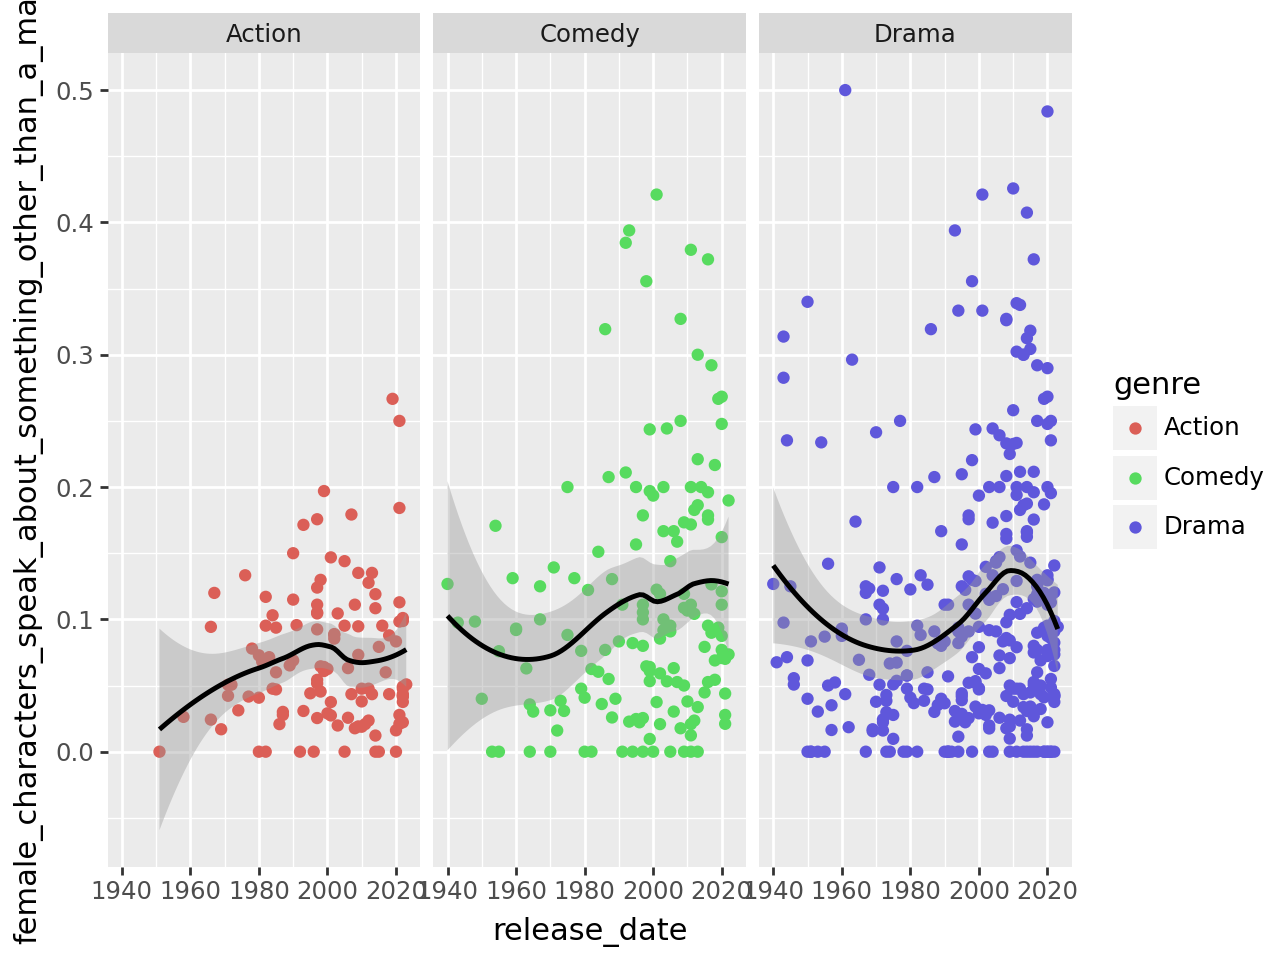

In [15]:
plot_trends('female_characters_speak_about_something_other_than_a_man')

In [16]:
import plotnine as p9
p9.options.figure_size=8,7

def plot_boxplot(y='female_characters_speak_about_something_other_than_a_man'):
    # gd={'Music':'Musical'}
    # dfall2['genre']=dfall2['genre'].apply(lambda x: gd.get(x,x))
    genres=dfall2.genre.value_counts()
    genres=genres[genres>=20].index
    genreorder=dfall2.groupby('genre')[y].median().sort_values(ascending=False).index
    dfall2['genre']=pd.Categorical(dfall2['genre'], categories=genreorder)
    figdf=dfall2[dfall2.genre.isin(genres)]
    genreorderl=[g for g in genreorder if g in genres]
    fig=p9.ggplot(figdf[figdf.genre!=""], p9.aes(x='genre', y=y))
    fig+=p9.geom_boxplot(outlier_shape='')
    fig+=p9.geom_point(shape='x')
    fig+=p9.coord_flip()
    fig+=p9.scale_x_discrete(limits=genreorderl)
    # fig+=p9.theme_minimal()
    fig+=p9.labs(
        x='Primary genre of film',
        y=f'% scenes in which {y.replace("_"," ")}',
        title='Comparing genres for Bechdel test'
    )
    return fig

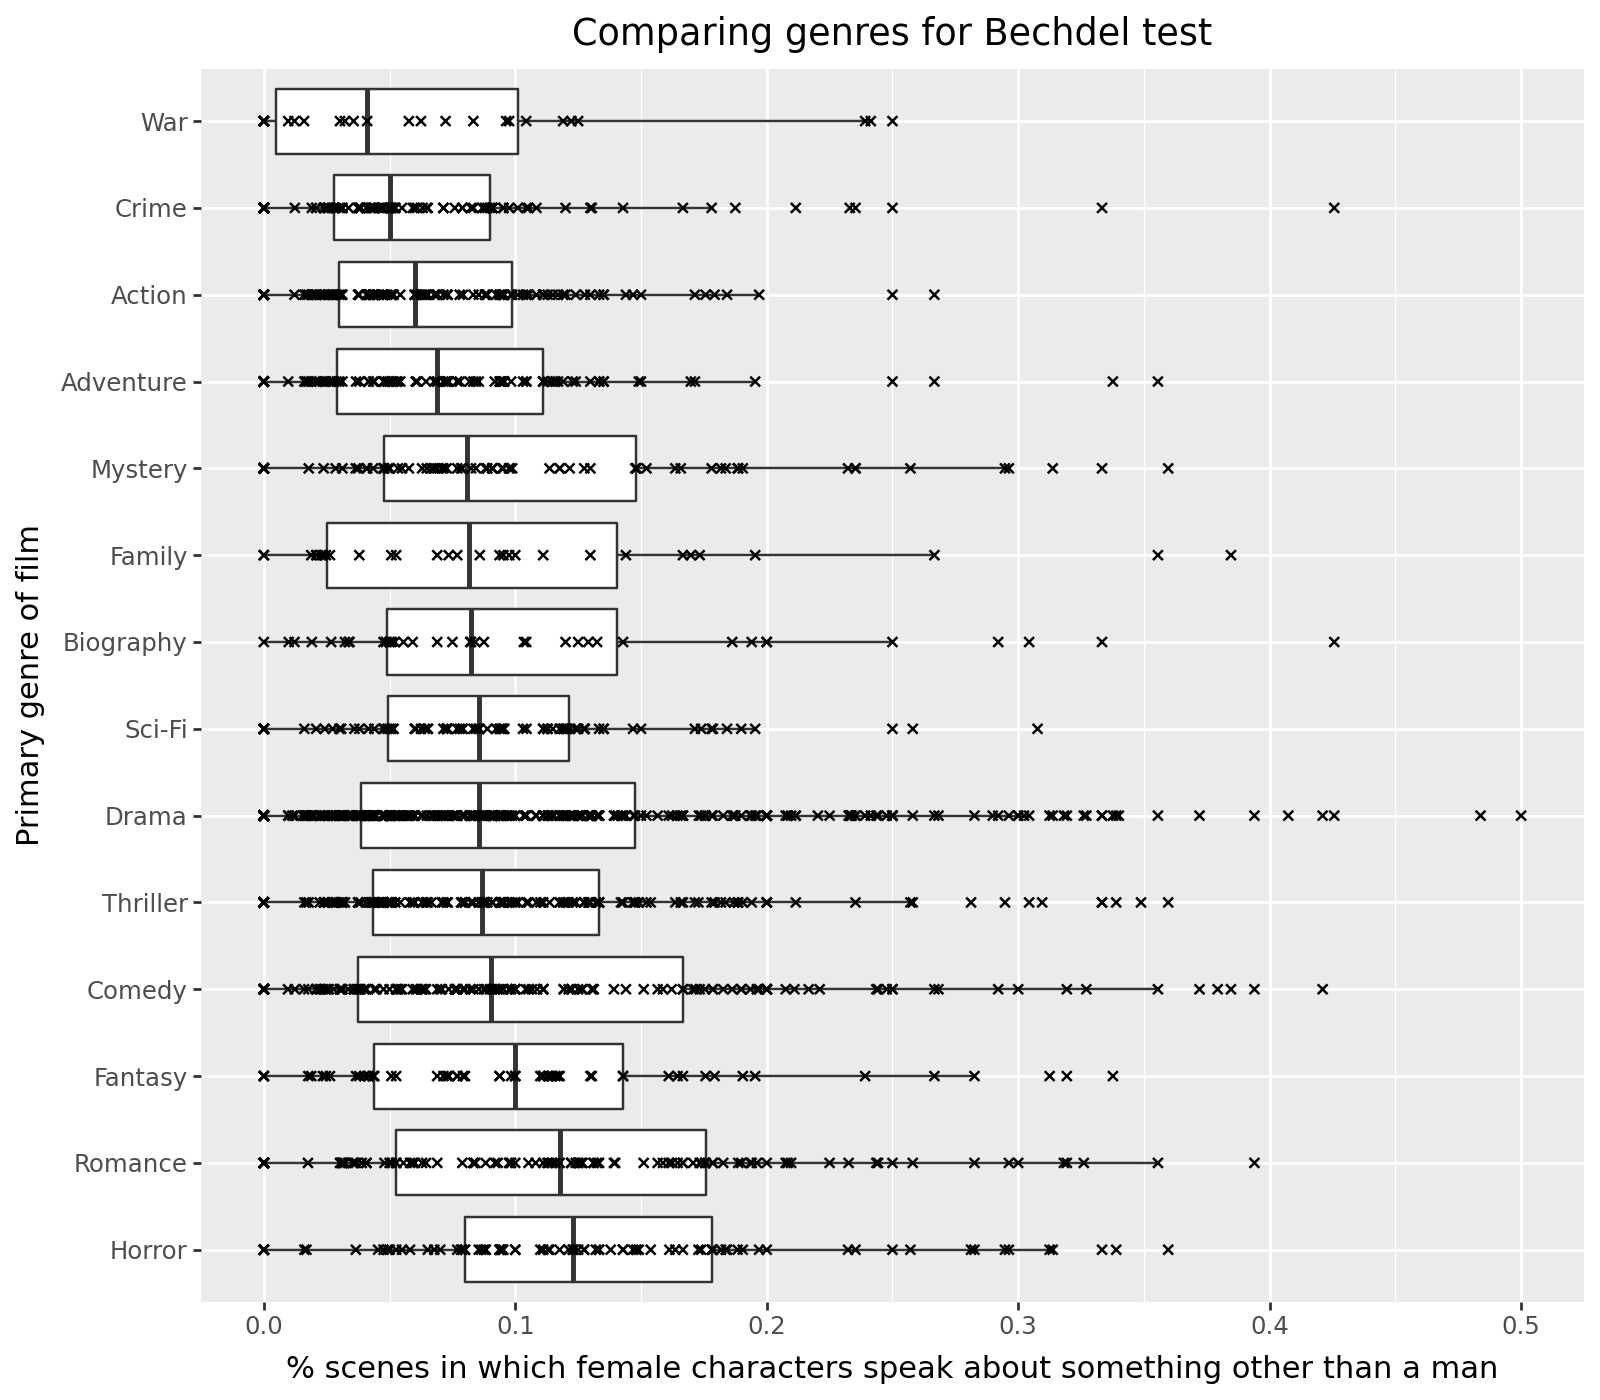

In [17]:
plot_boxplot()

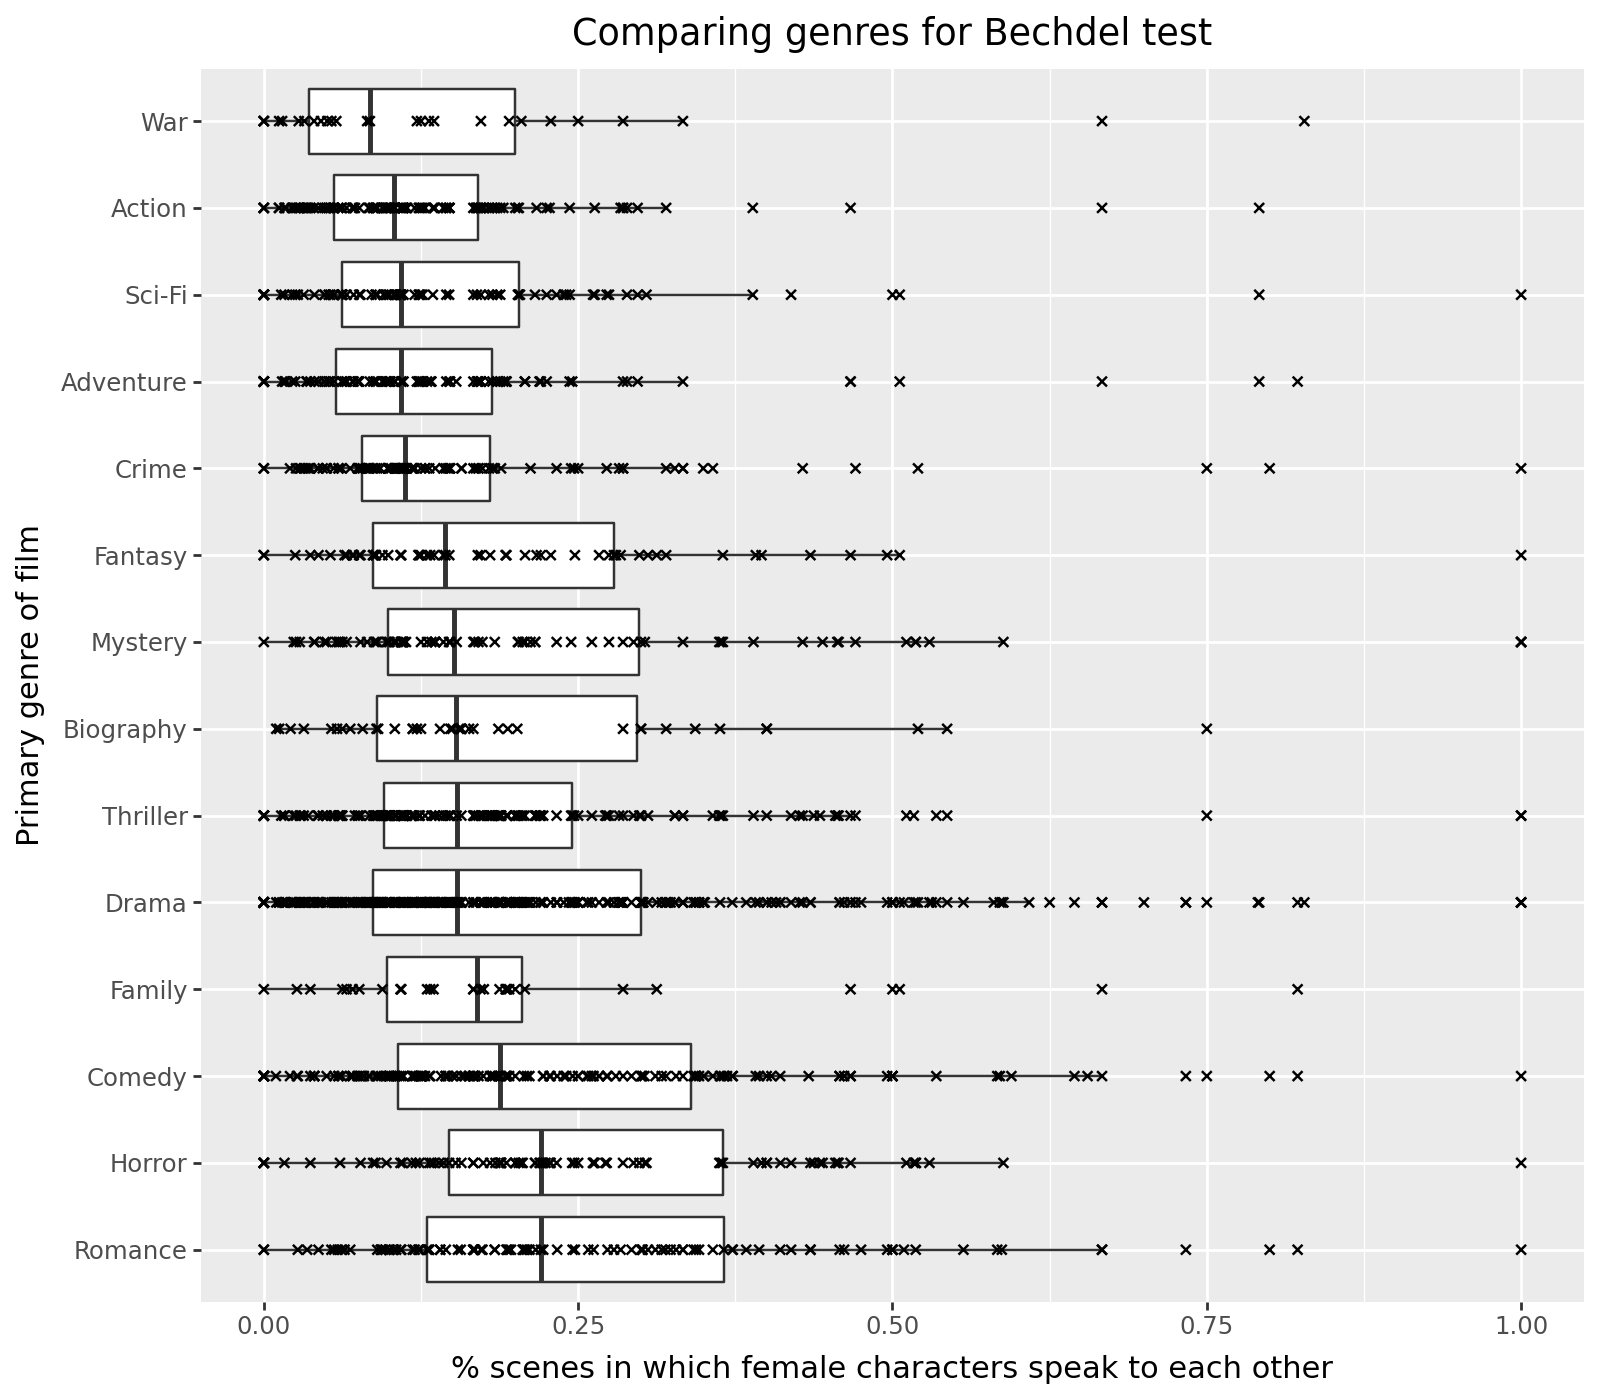

In [18]:
plot_boxplot('female_characters_speak_to_each_other')

In [31]:
dfall2[dfall2.genre=='Romance'].sort_values('female_characters_speak_to_each_other')

,female_characters_speak_to_each_other,female_characters_speak_about_something_other_than_a_man,scene_num,num_female_characters,num_male_characters,name,source,file_name,script_url,tmdb_title,title,tmdb_release_date,release_date,tmdb_id,tmdb_overview,overview,imdb_title,imdb_release_date,imdb_id,dec,genre
id,,,,,,,,,,,,,,,,,,,,,
Scarlet-Letter-The,0.000000,0.125000,72.791667,1.250000,1.500000,"Scarlet Letter, The",sfy,Scarlet-Letter-The,https://sfy.ru/?script=scarlet_letter_1926,The Scarlet Letter,The Scarlet Letter,1995-10-13,1995.0,10533.0,"Set in puritanical Boston in the mid 1600s, th...","Set in puritanical Boston in the mid 1600s, th...",The Scarlet Letter,1995.0,114345,1990.0,Romance
Artist-The,0.000000,0.000000,120.000000,0.000000,2.000000,"Artist, The",actorpoint,Artist-The,https://www.actorpoint.com/movie-scripts/scrip...,The Artist,The Artist,2011-10-12,2011.0,74643.0,"Hollywood, 1927: As silent movie star George V...","Hollywood, 1927: As silent movie star George V...",The Artist,2011.0,1655442,2010.0,Romance
Real-Genius,0.027027,0.036036,106.585586,0.342342,2.882883,Real Genius,dailyscript,Real-Genius,https://www.dailyscript.com/scripts/real_geniu...,Real Genius,Real Genius,1985-08-07,1985.0,14370.0,Chris is the top brain who just wants to party...,Chris is the top brain who just wants to party...,Real Genius,1985.0,89886,1980.0,Romance
Kong-(King-Kong),0.034483,0.000000,124.310345,0.275862,3.068966,Kong (King Kong),dailyscript,Kong-(King-Kong),https://www.dailyscript.com/scripts/kong1933.html,Godzilla vs. Kong,King Kong,2021-03-24,2005.0,399566.0,"In a time when monsters walk the Earth, humani...","In a time when monsters walk the Earth, humani...",King Kong,2005.0,360717,2000.0,Romance
Legend-of-Darkness,0.043478,0.115942,59.695652,0.681159,2.362319,Legend of Darkness,screenplays,Legend-of-Darkness,https://www.screenplays-online.de/screenplay.p...,Legend,Legend,1985-08-28,1985.0,11976.0,Set in a timeless mythical forest inhabited by...,Set in a timeless mythical forest inhabited by...,Legend,1985.0,89469,1980.0,Romance
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Last-of-the-Mohicans-The,0.666667,0.000000,2.000000,2.666667,9.333333,"Last of the Mohicans, The",imsdb,Last-of-the-Mohicans-The,https://imsdb.com/scripts/Last-of-the-Mohicans...,The Last of the Mohicans,The Last of the Mohicans,1992-08-26,1992.0,9361.0,"In war-torn Colonial America, in the midst of ...","In war-torn Colonial America, in the midst of ...",The Last of the Mohicans,1992.0,104691,1990.0,Romance
Shadows-Of-Time,0.733333,0.133333,10.600000,2.133333,4.266667,Shadows Of Time,scriptsavant,Shadows-Of-Time,https://secureservercdn.net/198.71.233.72/p2z....,Shadows of Time,Shadows of Time,2005-11-06,2004.0,37471.0,Ravi and Masha are just children when they wer...,Ravi and Masha are just children when they wer...,Shadows of Time,2004.0,360960,2000.0,Romance
Trouble-In-Paradise,0.800000,0.000000,3.000000,4.200000,6.400000,Trouble In Paradise,scriptsavant,Trouble-In-Paradise,https://secureservercdn.net/198.71.233.72/p2z....,Trouble in Paradise,Trouble in Paradise,1932-10-30,1932.0,195.0,Thief Gaston Monescu and pickpocket Lily are p...,Thief Gaston Monescu and pickpocket Lily are p...,Trouble in Paradise,1932.0,23622,1930.0,Romance


In [40]:
len(dfall)

558

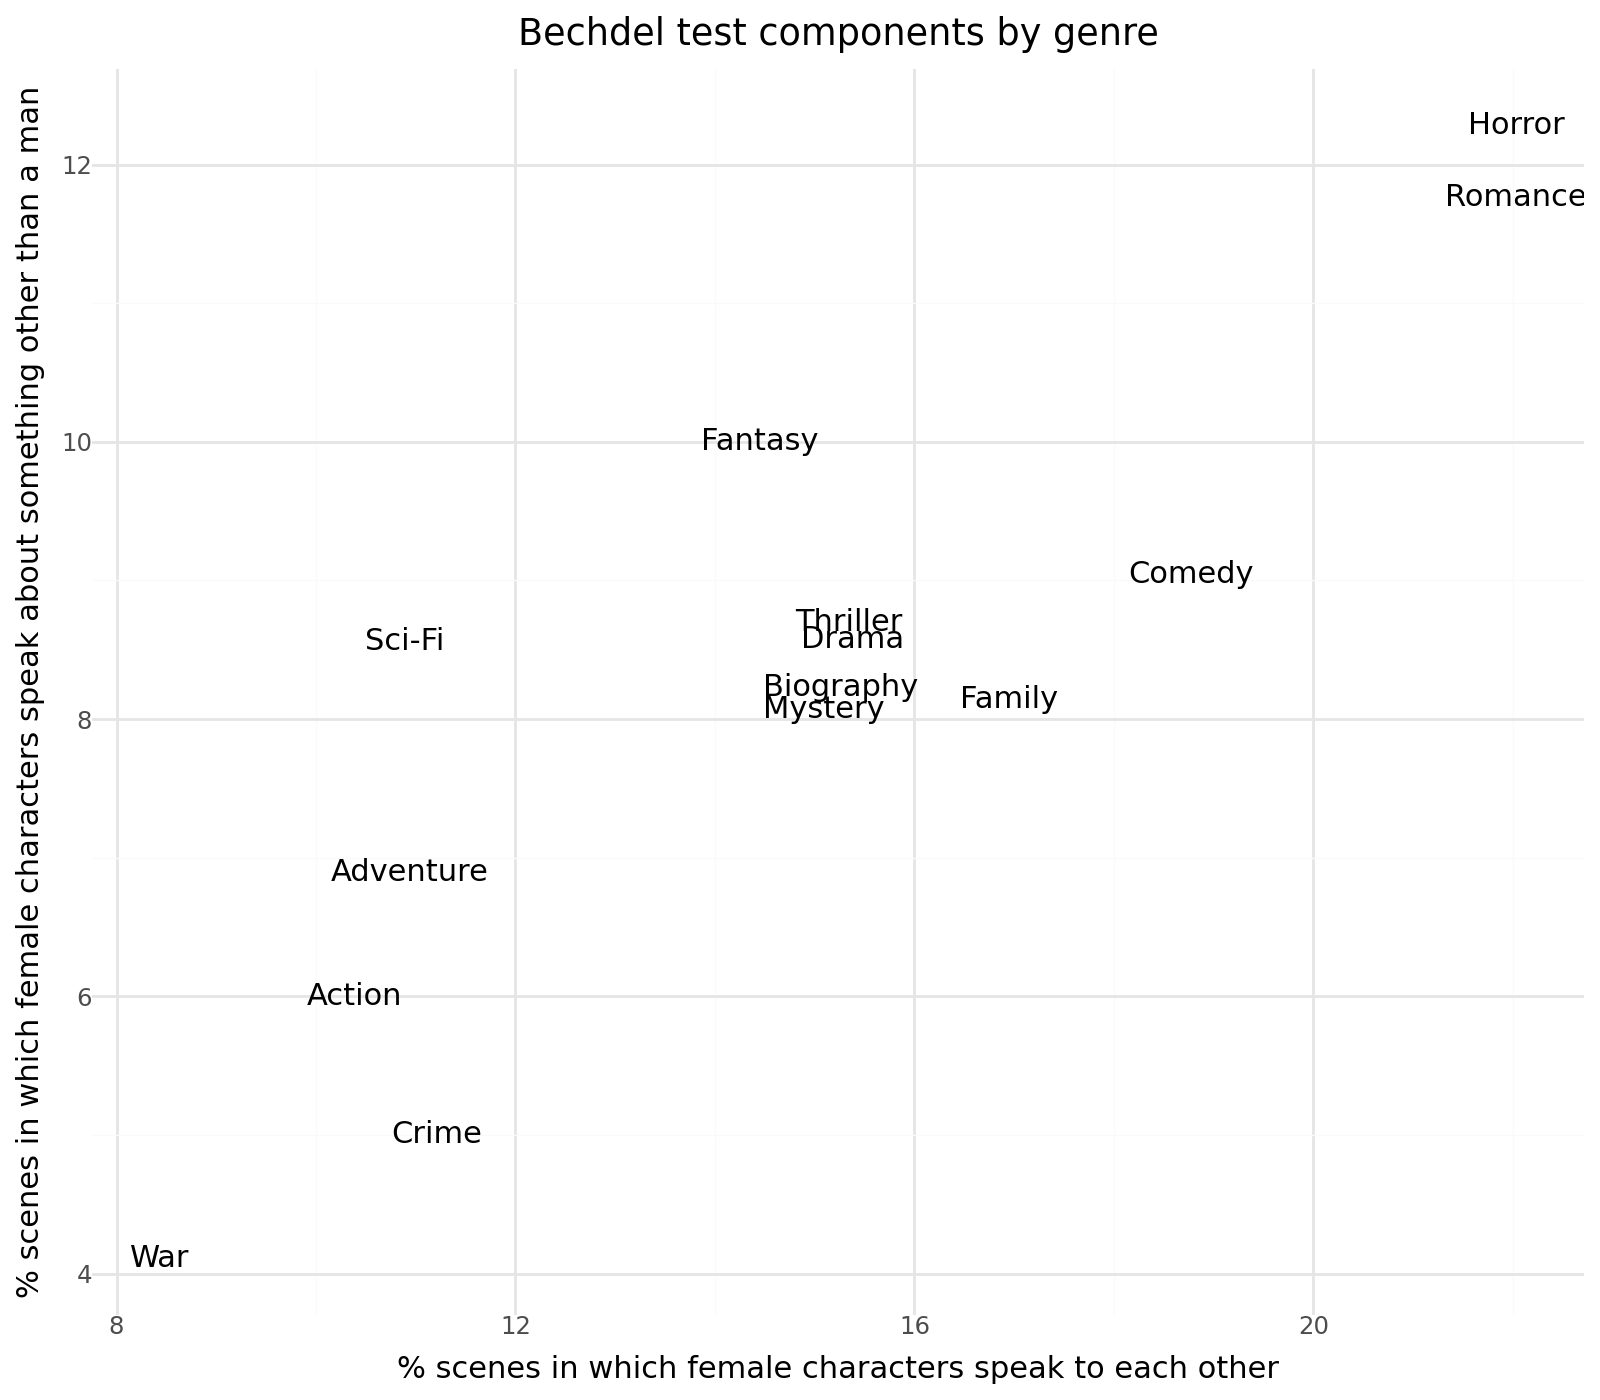

In [38]:
def plot_genre_biplot(x='female_characters_speak_to_each_other', y='female_characters_speak_about_something_other_than_a_man'):
    figdf=pd.concat(gdf for g,gdf in dfall2.groupby('genre') if len(gdf)>=20)
    figdf[x]*=100
    figdf[y]*=100
    dfgenres=figdf.groupby('genre').median(numeric_only=True)
    dfgenres['count']=figdf.genre.value_counts()
    fig = p9.ggplot(dfgenres.reset_index(), p9.aes(x=x, y=y, label='genre'))
    # fig += p9.geom_point(p9.aes(size='count'), alpha=.25)
    fig += p9.geom_text()
    # fig += p9.geom_abline(intercept=0, slope=1, color='blue')
    # fig += p9.scale_x_continuous(limits=(0,25))
    # fig += p9.scale_y_continuous(limits=(0,12.5))
    fig+=p9.theme_minimal()
    fig+=p9.labs(
        x=f'% scenes in which {x.replace("_", " ")}',
        y=f'% scenes in which {y.replace("_", " ")}',
        title='Bechdel test components by genre'
    )
    fig.save('fig.genre_biplot.png')
    return fig

plot_genre_biplot()

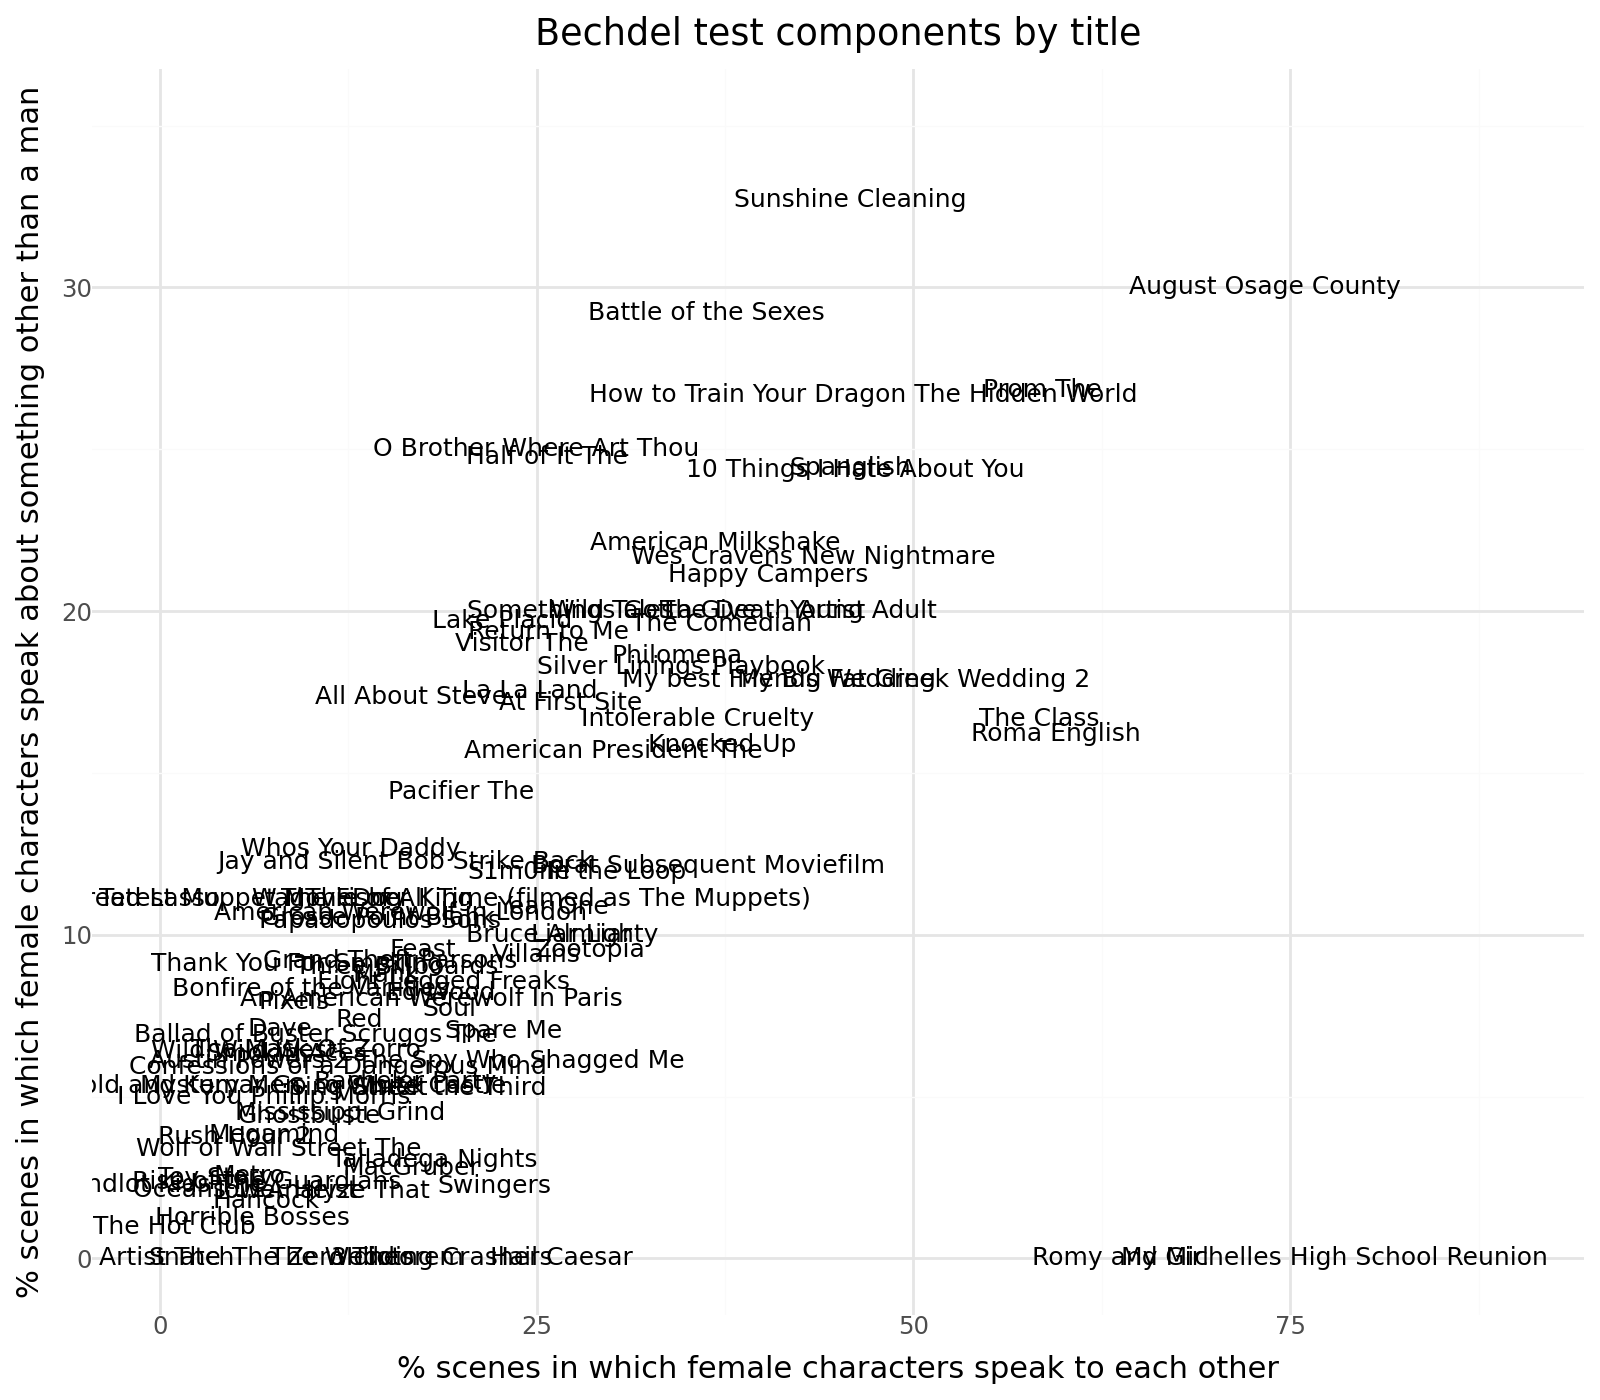

In [20]:
def plot_film_biplot(x='female_characters_speak_to_each_other', y='female_characters_speak_about_something_other_than_a_man'):
    figdf=dfall2.query('genre=="Comedy"').copy().reset_index()
    figdf[x]*=100
    figdf[y]*=100
    figdf['id']=figdf['id'].apply(lambda x: x.replace('-',' '))
    fig = p9.ggplot(figdf.query('1990<=release_date'), p9.aes(x=x, y=y, label='id'))
    # fig += p9.geom_point(alpha=.25)
    fig += p9.geom_text(size=9)
    # fig += p9.geom_abline(intercept=0, slope=1, color='blue')
    fig += p9.scale_x_continuous(limits=(0,90))
    fig += p9.scale_y_continuous(limits=(0,35))
    fig+=p9.theme_minimal()
    fig+=p9.labs(
        x=f'% scenes in which {x.replace("_", " ")}',
        y=f'% scenes in which {y.replace("_", " ")}',
        title='Bechdel test components by title'
    )
    fig.save('fig.title_biplot.png')
    return fig

plot_film_biplot()

In [41]:
anndata['perc_rhyming_lines']

NameError: name 'anndata' is not defined